In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# EMD Is Just MSE (Kinda)

*Mar 31, 2023*

---------------------------

Comparison of data distributions is a frequent task in machine learning and data science. It arised all over the field. In deep learning, in particular, there's at least one famous context for it: minimizing the difference between the distribution of latents gaussian distribution during VAE training. It is traditionally solved by minimizing a [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). Training GANs is essentially a distribution matching problem. This distribution matching problem is very complex and requires a whole neural network (discriminator) to compare distributions. But smaller distribution matching subproblems arise all over GANs, which can be solved explicitly using some metric, distance or divergence on distributions. One such distance is [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric) and [Earth Mover's Distance (EMD)](https://en.wikipedia.org/wiki/Earth_mover%27s_distance) in particular. So let's talk about one particular interpretation of EMD.

# Earth Mover's Distance Primer

We often deal with histograms when working with distributions. What is an EMD between two histograms? Generally speaking, it is a solution to an [optimal transport problem](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics)). The popular explanation goes like this. Imagine our histograms $h$ and $g$ being two piles of dirt, both having mass 1. Let's set the cost of moving a unit of dirt from location $i$ to location $j$ as $c_{ij} \geq 0$. It is often set to be just the distance between $i$ and $j$: $c_{ij} = |i - j|$. And let's define transport $p_{ij}$ as the amount of dirt to be moved between locations $i$ and $j$. The amount of dirt in two piles is the same, so there exists at least one transport plan $P = \{ p_{ij} \}$ which transforms one pile into another. Each such plan has a total cost associated with it as $ C = \sum_{i,j} p_{ij} |i - j| $. The EMD then is the minimal total cost of reshaping one pile into another. 

$$ W(h, g) = \min_{P \in \Pi} \sum_{i,j} p_{ij} |i - j| $$

where $\Pi$ is a set of all possible transport plans. This is a standard formulation and interpretation of the Earth Mover's Distance. But let's fix one annoying flaw in this formulation. Consider that the maximum possible cost for a transport plan happens when the whole mass must be transferred from the first bin to the last one. Therefore EMD has a trivial upper bound:

$$ W(h, g) < n $$

where $n$ is the number of bins in the histogram. We usually do not want our distance measure to grow just because we made our histograms more detailed. To fix that and make things prettier let's simply scale the EMD:

$$ W(h, g) = \min_{P \in \Pi} \frac{1}{n} \sum_{i,j} p_{ij} |i - j| $$

Fun Fact: the algorithm for EMD between two histograms looks exactly like a bulldozer which moves left to right and pushes excess dirt into "holes". It even can be expressed with a closed-form formula:

$$ W(h, g) = \frac{1}{n} \sum_{m=1}^{n} \left| \textstyle \sum_{i=1}^{m} h_i - \sum_{i=1}^{m} g_i \right| $$

or simply speaking, it's an integral of the absolute difference of two CDFs, represented by cumulative sums here. This formula can be implemented as a PyTorch one-liner and is easily differentiable. The gradient isn't the most pleasant one though.

# Geometric View

But let's look at the EMD from a different, geometric perspective. A histogram can be viewed as a vector $h = \left[ b_1, b_2, ..., b_n \right]^T, b_i \geq 0$. The sum of its components is 1 for it to represent a proper histogram. So every histogram lives on a simplex $S$ spanned by unit basis vectors in $\mathbb{R}^n$. Any transport plan $P$ preserves the histogram normalization and every step $p_{ij}$ becomes a displacement vector which keep the histogram in $S$:

$$ h_0 = h $$
$$ h_N = g $$
$$ h_k = h_{k-1} + p_k, h_k \in S $$

Therefore:

$$ P = g - h = \sum_{k=1}^{N} p_k$$

For everything to make sense, these vectors $p_k$ must be coplanar to a $(i_k, j_k)$ coordinate plane, where $i_k$ and $j_k$ are indices of bins between which the mass exchange is performed on the step $k$. Nothings beats a good visualization, so here's a nice 3D example:

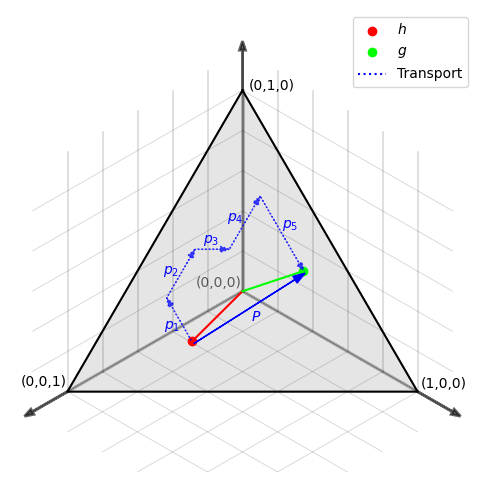

In [2]:
def plot_axes_3d(mark_coord = True):
    vx = [np.cos(3*np.pi/6), np.cos(-np.pi/6), np.cos(7*np.pi/6)]
    vy = [np.sin(3*np.pi/6), np.sin(-np.pi/6), np.sin(7*np.pi/6)]

    # Axis
    for i in range(3):
        plt.arrow(0, 0, vx[i], vy[i], head_width = 0, color = 'black', lw = 2, alpha = 0.25);

    for i in range(3):
        plt.arrow(vx[i], vy[i], 0.2*vx[i], 0.2*vy[i], head_width = 0.03, color = 'black', lw = 2, alpha = 0.6);
       
    if mark_coord:
        plt.text(-0.23, 0.02, s = '(0,0,0)', alpha = 0.6)
        plt.text(vx[0] + 0.03, vy[0] + 0.0, s = '(0,1,0)')
        plt.text(vx[1] + 0.015, vy[1] + 0.02, s = '(1,0,0)')
        plt.text(vx[2] - 0.23, vy[2] + 0.03, s = '(0,0,1)')

    # Grid
    for i in range(3):
        for j in range(3):
            if i == j:
                continue
            for s in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
                plt.arrow(s*vx[j], s*vy[j], 1.2*vx[i], 1.2*vy[i], head_width = 0, color = 'black', lw = 0.5, alpha = 0.1);


    # Simplex
    simplex = plt.Polygon(np.array([vx, vy]).T, color = 'black', alpha = 0.1, )
    plt.gca().add_patch(simplex)
    plt.plot(vx + vx[:1], vy + vy[:1], 'k-', )

    # H and G
    h = [-0.25, -0.25]
    g = [0.3, 0.1]
    plt.plot([0, h[0]], [0, h[1]], color = 'red')
    plt.scatter(*h, color = 'red', label = '$h$')

    plt.plot([0, g[0]], [0, g[1]], color = 'lime')
    plt.scatter(*g, color = 'lime', label = '$g$')
    return h, g
    
plt.figure(figsize = (6,6))
h, g = plot_axes_3d()

# Transport
cfg = dict(length_includes_head = True, head_width = 0.03, lw = 1, color = 'blue', linestyle = ':', alpha = 0.75)
ux = [np.cos(0*np.pi/3), np.cos(1*np.pi/3), np.cos(2*np.pi/3)]
uy = [np.sin(0*np.pi/3), np.sin(1*np.pi/3), np.sin(2*np.pi/3)]

P = [
    [(0.25, 2), (0.28, 1), (0.17, 0), (0.305, 1), (-0.433, 2)],
]
t = [[h[0], h[1]]]
for p in P[0]:
    t.append([t[-1][0] + p[0]*ux[p[1]], t[-1][1] + p[0]*uy[p[1]]])
    plt.arrow(t[-2][0], t[-2][1], p[0]*ux[p[1]], p[0]*uy[p[1]], **cfg)
plt.arrow(h[0] + 0.01, h[1]-0.01, g[0] - h[1], g[1] - h[1], length_includes_head = True, head_width = 0.04, lw = 1, color = 'blue')

plt.text(h[0] + 0.29, h[1] + 0.1, s = '$P$', color = 'blue')
plt.text(t[0][0] - 0.14, t[0][1] + 0.06, s = '$p_1$', color = 'blue')
plt.text(t[1][0] - 0.02, t[1][1] + 0.12, s = '$p_2$', color = 'blue')
plt.text(t[2][0] + 0.04, t[2][1] + 0.03, s = '$p_3$', color = 'blue')
plt.text(t[3][0] - 0.01, t[3][1] + 0.14, s = '$p_4$', color = 'blue')
plt.text(t[4][0] + 0.11, t[4][1] - 0.16, s = '$p_5$', color = 'blue')

plt.plot([-2], [-2], 'b:', label = 'Transport')  # Just for the label

plt.xlim(-1.15, 1.15)
plt.ylim(-0.9, 1.4)
plt.axis('off')
plt.legend();

On the image above a histogram simplex is shown with an example of a transport plan between $h$ and $g$ drawn in blue. This transport plan is probably not the most optimal one and cannot serve for the EMD. Some observations we can make:

1. For any two $n$-histograms you need no more than $n-1$ steps to transform one into another. This comes from two facts:
   1. Our simplex space is exactly $n-1$ dimensional
   2. We can convert between the histogram space and the simplex space by a simple change of the basis, and every vector in the simplex space is represented as a sum of no more than $n-1$ basis vectors
   
2. Each transport plan is actually an equivalence class of more "detailed" plans, obtained by splitting any transport vector into multiple parts: $p_k = \sum_{i=1}^{m} p_{ki}$ where $p_{ki} = w_{ki} p_k$ with $w_{ki}$ beings positive weights summing up to 1.

3. More so, we can take all sub-steps $p_{ki}$ and shuffle them in any way, which preserves continuity of the whole transport plan and ensures that the new plan still adds up to $P$. This is true because by splitting $p_k$ we just split the mass transferred, and by shuffling them we change only at which step this smaller mass is transferred, but the destination stays the same, thus the whole flow between each pair of bins stays the same.

Let's look at an example:

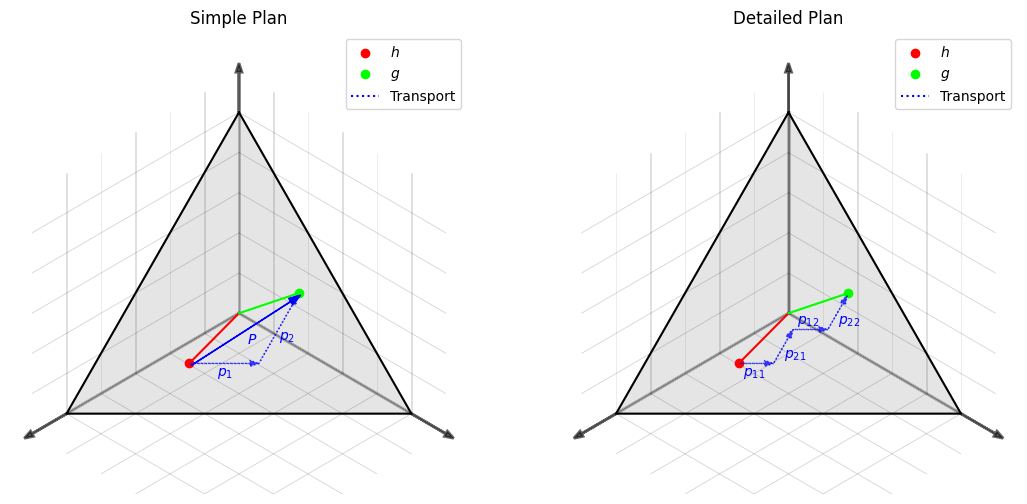

In [3]:
plt.figure(figsize = (13,6))

plt.subplot(1,2,1)
plt.title("Simple Plan")
h, g = plot_axes_3d(mark_coord = False)

# Transport
cfg = dict(length_includes_head = True, head_width = 0.03, lw = 1, color = 'blue', linestyle = ':', alpha = 0.75)
ux = [np.cos(0*np.pi/3), np.cos(1*np.pi/3), np.cos(2*np.pi/3)]
uy = [np.sin(0*np.pi/3), np.sin(1*np.pi/3), np.sin(2*np.pi/3)]

P = [
    [(0.35, 0), (0.39, 1)],
]
t = [[h[0], h[1]]]
for p in P[0]:
    t.append([t[-1][0] + p[0]*ux[p[1]], t[-1][1] + p[0]*uy[p[1]]])
    plt.arrow(t[-2][0], t[-2][1], p[0]*ux[p[1]], p[0]*uy[p[1]], **cfg)
plt.arrow(h[0] + 0.01, h[1]-0.01, g[0] - h[1], g[1] - h[1], length_includes_head = True, head_width = 0.04, lw = 1, color = 'blue')

plt.text(h[0] + 0.29, h[1] + 0.1, s = '$P$', color = 'blue')
plt.text(t[0][0] + 0.14, t[0][1] - 0.06, s = '$p_1$', color = 'blue')
plt.text(t[1][0] + 0.1, t[1][1] + 0.12, s = '$p_2$', color = 'blue')
# plt.text(t[3][0] - 0.01, t[3][1] + 0.14, s = '$p_4$', color = 'blue')
# plt.text(t[4][0] + 0.11, t[4][1] - 0.16, s = '$p_5$', color = 'blue')

plt.plot([-2], [-2], 'b:', label = 'Transport')  # Just for the label

plt.xlim(-1.15, 1.15)
plt.ylim(-0.9, 1.4)
plt.axis('off')
plt.legend()

plt.subplot(1,2,2)
plt.title('Detailed Plan')
h, g = plot_axes_3d(mark_coord = False)

# Transport
cfg = dict(length_includes_head = True, head_width = 0.03, lw = 1, color = 'blue', linestyle = ':', alpha = 0.75)
ux = [np.cos(0*np.pi/3), np.cos(1*np.pi/3), np.cos(2*np.pi/3)]
uy = [np.sin(0*np.pi/3), np.sin(1*np.pi/3), np.sin(2*np.pi/3)]

P = [
    [(0.175, 0), (0.195, 1), (0.175, 0), (0.195, 1)],
]
t = [[h[0], h[1]]]
for p in P[0]:
    t.append([t[-1][0] + p[0]*ux[p[1]], t[-1][1] + p[0]*uy[p[1]]])
    plt.arrow(t[-2][0], t[-2][1], p[0]*ux[p[1]], p[0]*uy[p[1]], **cfg)

plt.text(t[0][0] + 0.02, t[0][1] - 0.06, s = '$p_{11}$', color = 'blue')
plt.text(t[1][0] + 0.05, t[1][1] + 0.03, s = '$p_{21}$', color = 'blue')
plt.text(t[2][0] + 0.02, t[2][1] + 0.03, s = '$p_{12}$', color = 'blue')
plt.text(t[3][0] + 0.05, t[3][1] + 0.03, s = '$p_{22}$', color = 'blue')

plt.plot([-2], [-2], 'b:', label = 'Transport')  # Just for the label

plt.xlim(-1.15, 1.15)
plt.ylim(-0.9, 1.4)
plt.axis('off')
plt.legend();

As you can imagine, we can take this to the limit and split the "simple" plan into infinitesimal parts and stitch them in any zig-zag curve we like. The natural idea would be to continue the "detalization" steps recursively cutting new sub-steps in two and bend corners inward bringing the trajectory closer and closer to the vector $P$ and then call it a day. Unfortunately, because this operation does not change the length of the trajectory, even in a limit we get not a vector $P$, but a fractal shape of the same length as our initial "simple" plan. 

How does the optimal transport plan look like then in our example? There are actually two of them. Here's the first one:

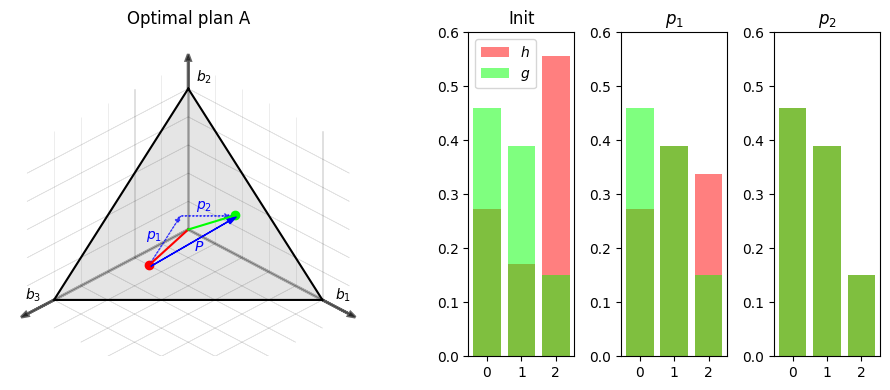

In [4]:
plt.figure(figsize = (9, 4))

plt.subplot(1,2,1)
plt.title("Optimal plan A")
hc, gc = plot_axes_3d(mark_coord = False)
plt.text(0.95, -0.5, s = '$b_1$', color = 'black')
plt.text(0.05, 1.05, s = '$b_2$', color = 'black')
plt.text(-1.05, -0.5, s = '$b_3$', color = 'black')

P = [
    [(0.4, 1), (0.33, 0)],
]
t = [[hc[0], hc[1]]]
for p in P[0]:
    t.append([t[-1][0] + p[0]*ux[p[1]], t[-1][1] + p[0]*uy[p[1]]])
    plt.arrow(t[-2][0], t[-2][1], p[0]*ux[p[1]], p[0]*uy[p[1]], **cfg)
plt.arrow(hc[0] + 0.01, hc[1]-0.01, gc[0] - hc[1], gc[1] - hc[1], length_includes_head = True, head_width = 0.04, lw = 1, color = 'blue')

plt.text(hc[0] + 0.29, hc[1] + 0.1, s = '$P$', color = 'blue')
plt.text(t[0][0] - 0.02, t[0][1] + 0.18, s = '$p_1$', color = 'blue')
plt.text(t[1][0] + 0.1, t[1][1] + 0.05, s = '$p_2$', color = 'blue')
plt.plot([-2], [-2], 'b:', label = 'Transport')  # Just for the label

plt.xlim(-1.15, 1.15)
plt.ylim(-0.9, 1.4)
plt.axis("off")

plt.subplot(1,6,4)
plt.title("Init")
h = np.array([0.27, 0.17, 0.55])
h = h / h.sum()
g = np.array([0.46, 0.39, 0.15])
g = g / g.sum()
plt.bar(np.arange(3), h, alpha = 0.5, color = 'red', label = '$h$')
plt.bar(np.arange(3), g, alpha = 0.5, color = 'lime', label = '$g$')
plt.xticks([0,1,2], [0,1,2])
plt.ylim(0, 0.6)
plt.legend()

plt.subplot(1,6,5)
plt.title("$p_1$")
t = g[1] - h[1]
h[2] -= t
h[1] += t
plt.bar(np.arange(3), h, alpha = 0.5, color = 'red')
plt.bar(np.arange(3), g, alpha = 0.5, color = 'lime')
plt.xticks([0,1,2], [0,1,2])
plt.ylim(0, 0.6)

plt.subplot(1,6,6)
plt.title("$p_2$")
t = g[0] - h[0]
h[2] -= t
h[0] += t
plt.bar(np.arange(3), h, alpha = 0.5, color = 'red')
plt.bar(np.arange(3), g, alpha = 0.5, color = 'lime')
plt.xticks([0,1,2], [0,1,2])
plt.ylim(0, 0.6)

plt.tight_layout();

The plan above goes like this:
1. $p_1$: $h_3 \rightarrow h_2$ - transport from bin 3 to bin 2
2. $p_2$: $h_3 \rightarrow h_1$ - move the excess from bin 3 to bin 1

The second one is different:

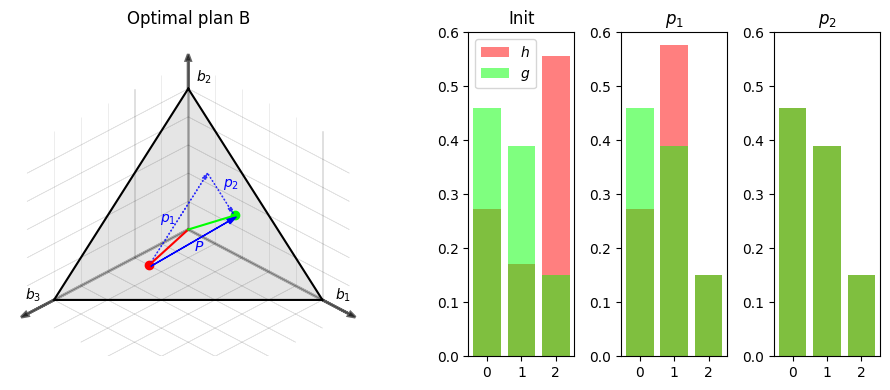

In [5]:
plt.figure(figsize = (9, 4))

plt.subplot(1,2,1)
plt.title("Optimal plan B")
hc, gc = plot_axes_3d(mark_coord = False)
plt.text(0.95, -0.5, s = '$b_1$', color = 'black')
plt.text(0.05, 1.05, s = '$b_2$', color = 'black')
plt.text(-1.05, -0.5, s = '$b_3$', color = 'black')

P = [
    [(0.75, 1), (-0.33, 2)],
]
t = [[hc[0], hc[1]]]
for p in P[0]:
    t.append([t[-1][0] + p[0]*ux[p[1]], t[-1][1] + p[0]*uy[p[1]]])
    plt.arrow(t[-2][0], t[-2][1], p[0]*ux[p[1]], p[0]*uy[p[1]], **cfg)
plt.arrow(hc[0] + 0.01, hc[1]-0.01, gc[0] - hc[1], gc[1] - hc[1], length_includes_head = True, head_width = 0.04, lw = 1, color = 'blue')

plt.text(hc[0] + 0.29, hc[1] + 0.1, s = '$P$', color = 'blue')
plt.text(t[0][0] + 0.07, t[0][1] + 0.3, s = '$p_1$', color = 'blue')
plt.text(t[1][0] + 0.1, t[1][1] - 0.1, s = '$p_2$', color = 'blue')
plt.plot([-2], [-2], 'b:', label = 'Transport')  # Just for the label

plt.xlim(-1.15, 1.15)
plt.ylim(-0.9, 1.4)
plt.axis("off")

plt.subplot(1,6,4)
plt.title("Init")
h = np.array([0.27, 0.17, 0.55])
h = h / h.sum()
g = np.array([0.46, 0.39, 0.15])
g = g / g.sum()
plt.bar(np.arange(3), h, alpha = 0.5, color = 'red', label = '$h$')
plt.bar(np.arange(3), g, alpha = 0.5, color = 'lime', label = '$g$')
plt.xticks([0,1,2], [0,1,2])
plt.ylim(0, 0.6)
plt.legend()

plt.subplot(1,6,5)
plt.title("$p_1$")
t = h[2] - g[2]
h[2] -= t
h[1] += t
plt.bar(np.arange(3), h, alpha = 0.5, color = 'red')
plt.bar(np.arange(3), g, alpha = 0.5, color = 'lime')
plt.xticks([0,1,2], [0,1,2])
plt.ylim(0, 0.6)

plt.subplot(1,6,6)
plt.title("$p_2$")
t = h[1] - g[1]
h[1] -= t
h[0] += t
plt.bar(np.arange(3), h, alpha = 0.5, color = 'red')
plt.bar(np.arange(3), g, alpha = 0.5, color = 'lime')
plt.xticks([0,1,2], [0,1,2])
plt.ylim(0, 0.6)

plt.tight_layout();

And is goes like this:
1. $p_1$: $h_3 \rightarrow h_2$ - move all excess from bin 3 to bin 2
2. $p_2$: $h_3 \rightarrow h_1$ - move the excess from bin 2 to bin 1

This plan really looks like a bulldozer pushing excess dirt into "holes".

These two plans are optimal and correspond to EMD $\approx$ 0.593, but the fact that they look completely different geometrically raises a question: what is common between them, which guarantees the equal minimal cost?

# Upper Bounds

We have clearly seen that it cannot be a length of the trajectory $p_k$ as the first and the second trajectory have different lengths but the same EMD. So what could it be? Because any trajectory regardless of its shape adds up to the vector $P$, then maybe some property of the vector $P$ can shed some light on the set of optimal transport plan trajectories. The instinctive first choice would be a euclidean norm of $P$. But remember, that histograms preserve a sum of elements and not their squares. So an $L_1$-norm seems to be more logical:

$$ \|P\|_1 = \sum_{i=1}^n |h_i - g_i| $$

Let's plot EMD against $\|P\|_1$ for random histograms with various number of bins:

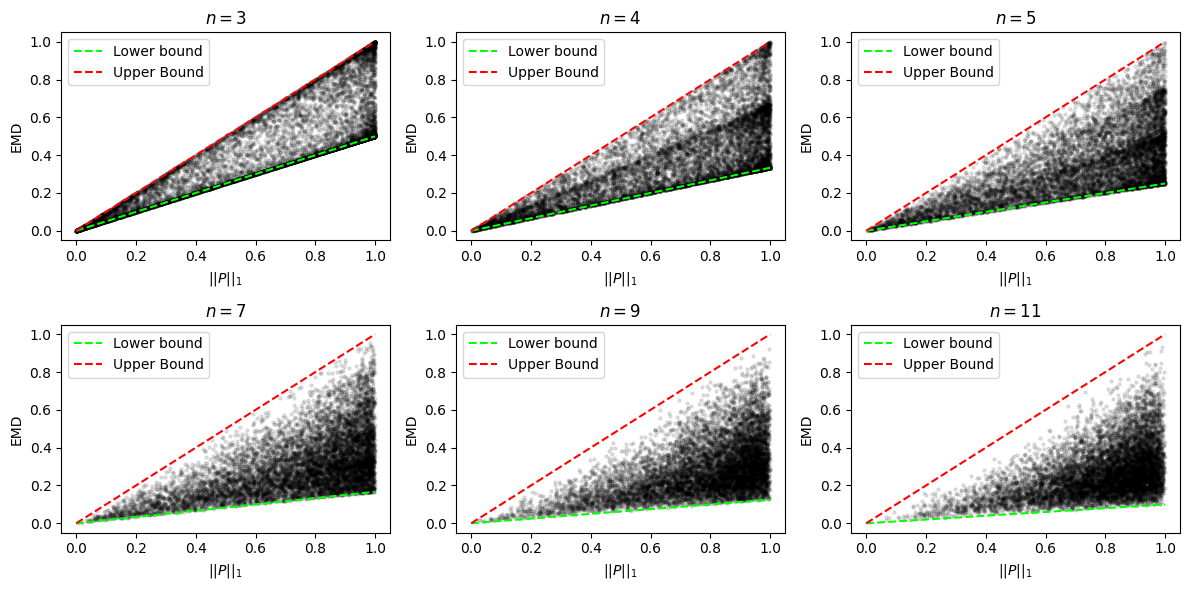

In [6]:
def emd(h, g):
    return np.sum(np.abs(np.cumsum(h - g))) / (h.size - 1)

def sample_histograms(n, k = 10000):
    L1 = []
    W = []
    
    for i in range(k):
        h = np.random.randn(n)**4
        h = h / h.sum()
        g = np.random.randn(n)**4
        g = g / g.sum()

        L1.append(0.5*np.linalg.norm(h - g, 1)) # np.dot(h, g) / np.linalg.norm(h) / np.linalg.norm(g)
        W.append(emd(h, g))
    return L1, W

plt.figure(figsize = (12, 6))
for i, n in enumerate([3, 4, 5, 7, 9, 11]):
    plt.subplot(2, 3, i + 1)
    plt.title(f"$n = {n}$")
    L1, W = sample_histograms(n)
    plt.scatter(L1, W, alpha = 0.1, s = 5, color = 'black')
    plt.plot([0, 1], [0, 1/(n - 1)], color = 'lime', linestyle = '--', label = "Lower bound")
    plt.plot([0, 1], [0, 1], 'r--', label = "Upper Bound")
    plt.xlabel("$\||P\||_1$")
    plt.ylabel("EMD")
    plt.legend()
plt.tight_layout();

Not bad! So the $L_1$-distance between two histograms provides us with the following upper bound on EMD:

$$ W(h, g) \leq \|h - g\|_1 $$

The darker stripes correspond to transports with particular cost and are smeared out by bigger variability in transported mass. But don't be distracted by the low density near the upper bound, it is just an artifact of sampling. 

Plots look nice, but let's prove this upper bound just to be sure. It's actually easy to do from the closed-form solution to the EMD:

$$ W(h, g) = \frac{1}{n} \sum_{m=1}^{n} \left| \textstyle \sum_{i=1}^{m} h_i - g_i \right| 
    \leq \frac{1}{n} \sum_{m=1}^{n} \sum_{i=1}^{m} \left|  h_i - g_i \right| < \\
    < \frac{1}{n} \sum_{m=1}^{n} \sum_{i=1}^{n} \left|  h_i - g_i \right|
    = \sum_{i=1}^{n} \left|  h_i - g_i \right| = \|h - g\|_1 $$

Interestingly, in [(Cohen, 1997)](http://i.stanford.edu/pub/cstr/reports/cs/tr/97/1597/CS-TR-97-1597.pdf) they prove a lower bound equal to distance between centroids of two distributions (Theorem 3.1). 

Because EMD is bounded by the $L_1$-norm from above, we can take the $L_1$-norm as a much simpler and easier to compute substitute for EMD. And it is also optimal in a sense that it has a constant rate of change, which means that reducing it by $\delta$ will reduce EMD by a proportional amount no matter what.

Now think of some monotone bounding function $f(x)$ for a moment. If it has some curvature, i.e. a changing derivative, it would induce higher pressure on EMD when $f'(x) > 1$, but a lower pressure when $f'(x) < 1$. Manhattan distance, however, doesn't have distinctive strong/weak regimes:

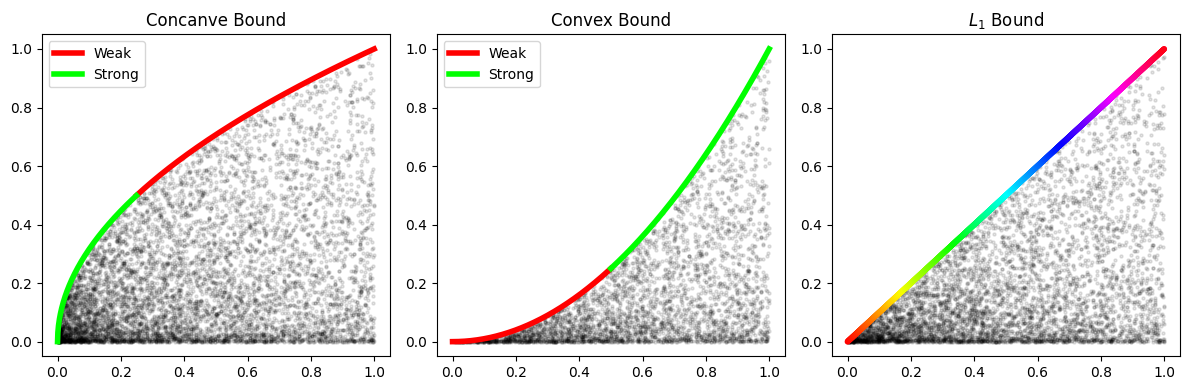

In [7]:
import matplotlib.cm as cmx

x = np.linspace(0, 1, 1001)
plt.figure(figsize = (12,4))

plt.subplot(1,3,1)
plt.title("Concanve Bound")
plt.plot(x[250:], np.sqrt(x[250:]), color = 'red', lw = 4, label = 'Weak')
plt.plot(x[:250], np.sqrt(x[:250]), color = 'lime', lw = 4, label = 'Strong')
u, v = np.random.randn(2, 10000)**2 % 1
mask = v < np.sqrt(u)
plt.scatter(u[mask], v[mask], alpha = 0.1, s = 5, color = 'black')
plt.legend()


plt.subplot(1,3,2)
plt.title("Convex Bound")
plt.plot(x[:500], np.square(x[:500]), color = 'red', lw = 4, label = 'Weak')
plt.plot(x[500:], np.square(x[500:]), color = 'lime', lw = 4, label = 'Strong')
u, v = np.random.randn(2, 10000)**2 % 1
mask = v < np.square(u)
plt.scatter(u[mask], v[mask], alpha = 0.1, s = 5, color = 'black')
plt.legend()

plt.subplot(1,3,3)
plt.title("$L_1$ Bound")
u, v = np.random.randn(2, 10000)**2 % 1
mask = v < u
plt.scatter(u[mask], v[mask], alpha = 0.1, s = 5, color = 'black')
plt.scatter(x, x, c = x, s = 10, cmap = 'hsv')
plt.tight_layout();

But for completeness let's take a look at some other distribution similarity measures in relation to EMD and check which upper and lower bounds the induce on it.

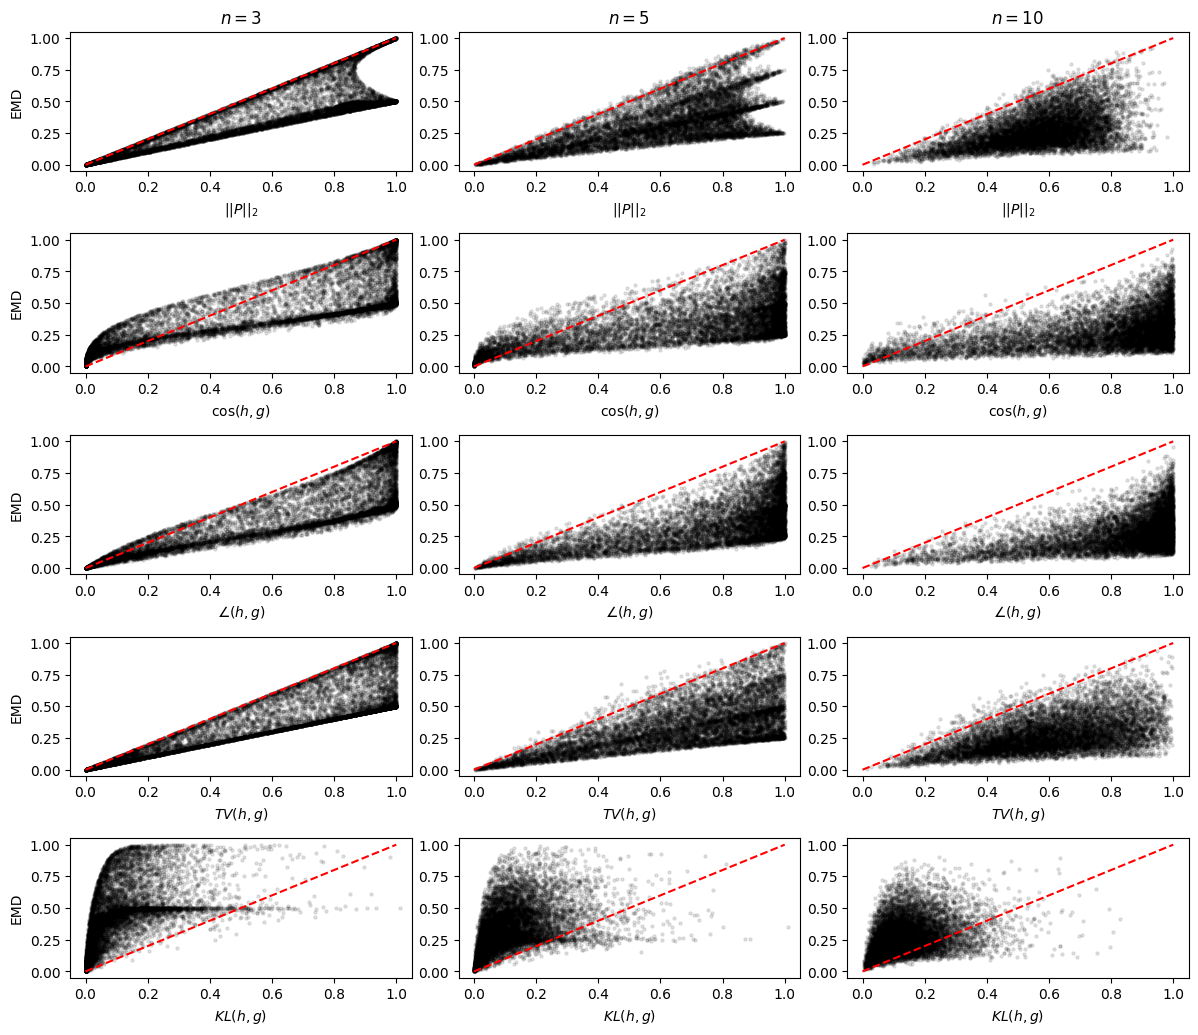

In [8]:
from numpy.linalg import norm

def emd(h, g):
    return np.sum(np.abs(np.cumsum(h - g))) / (h.size - 1)

def sample_histograms(n, k = 10000):
    H = []
    G = []
    W = []
    for i in range(k):
        h = np.random.randn(n)**4
        g = np.random.randn(n)**4
        h = h / h.sum()
        g = g / g.sum()
        H.append(h)
        G.append(g)
        W.append(emd(h, g))
    return np.stack(H), np.stack(G), W
    
plt.figure(figsize = (12, 12))

nrows = 6

for i, n in enumerate([3, 5, 10], 0):
    plt.subplot(nrows, 3, i + 1)
    plt.title(f"$n = {n}$")
    H, G, W = sample_histograms(n)
    X = norm(H - G, axis = 1) / np.sqrt(2)
    
    plt.scatter(X, W, alpha = 0.1, s = 5, color = 'black')
    plt.plot([0, 1], [0, 1], 'r--', label = "y = x")
    plt.xlabel("$\||P\||_2$")
    plt.ylabel("EMD") if i == 0 else None
    plt.xlim(-0.05, 1.05)
    
for i, n in enumerate([3, 5, 10], 3):
    plt.subplot(nrows, 3, i + 1)
    H, G, W = sample_histograms(n)
    X = 1 - np.sum(H*G, axis = 1) / norm(H, axis = 1) / norm(G, axis = 1)
    
    plt.scatter(X, W, alpha = 0.1, s = 5, color = 'black')
    plt.plot([0, 1], [0, 1], 'r--', label = "y = x")
    plt.xlabel("$\cos (h, g)$")
    plt.ylabel("EMD") if i == 3 else None
    plt.xlim(-0.05, 1.05)
    
for i, n in enumerate([3, 5, 10], 6):
    plt.subplot(nrows, 3, i + 1)
    H, G, W = sample_histograms(n)
    X = np.arccos(np.sum(H * G, axis = 1) / norm(H, axis = 1) / norm(G, axis = 1)) / np.pi * 2
    
    plt.scatter(X, W, alpha = 0.1, s = 5, color = 'black')
    plt.plot([0, 1], [0, 1], 'r--', label = "y = x")
    plt.xlabel("$\\angle (h, g)$")
    plt.ylabel("EMD") if i == 6 else None
    plt.xlim(-0.05, 1.05)
    
for i, n in enumerate([3, 5, 10], 9):
    plt.subplot(nrows, 3, i + 1)
    H, G, W = sample_histograms(n)
    X = np.max(np.abs(H - G), axis = 1)
    
    plt.scatter(X, W, alpha = 0.1, s = 5, color = 'black')
    plt.plot([0, 1], [0, 1], 'r--', label = "y = x")
    plt.xlabel("$TV(h, g)$")
    plt.ylabel("EMD") if i == 9 else None
    plt.xlim(-0.05, 1.05)
    
for i, n in enumerate([3, 5, 10], 12):
    plt.subplot(nrows, 3, i + 1)
    H, G, W = sample_histograms(n)
    X = np.sum(H * np.log(H / G), axis = 1) / 30
    
    plt.scatter(X, W, alpha = 0.1, s = 5, color = 'black')
    plt.plot([0, 1], [0, 1], 'r--', label = "y = x")
    plt.xlabel("$KL(h, g)$")
    plt.ylabel("EMD") if i == 12 else None
    plt.xlim(-0.05, 1.05)
    
plt.tight_layout();

That a lot to digest so let's start from the top:

1. The first row shows a Euclidean distance. Its induced upper bound is in general slightly concave but similar to Manhattan's
2. A cosine between two histogram vectors is also almost concave, and is a weaker bound for almost the whole range of values.
3. An angle between two histogram vectors a.k.a. $arccos(cos(h, g))$ is more complex but close to $L_1$
4. A total variation distance (a maximum absolute difference between histograms) is also slightly concave but close 
5. Kullback-Leibler divergence induces a highly concave bound which has almost no effect till very close to zero, but there it pushes real hard.

One notable example is the Kolmogorov-Smirnov distance which is equal to a maximum absolute difference but between CDFs:

$$ KS(h, g) = \max_{m = 1..n} \left| \sum_{i = 1}^{m} h_i - g_i \right|$$

It provides and even tighter upper bound on EMD:

$$ KS(h, g) = \max_{m=1..n} \left| \sum_{i=1}^{m} h_i - g_i \right| 
    \leq \max_{m=1..n} \sum_{i=1}^{m} |  h_i - g_i |
    = \sum_{i=1}^{n} | h_i - g_i | = \| h - g \|_1 $$
    
$$ W(h, g) 
    = \frac{1}{n} \sum_{m=1}^{n} \left| \textstyle \sum_{i=1}^{m} h_i - g_i \right| 
    \leq \frac{1}{n} \sum_{k=1}^{n} \max_{m=1..n} \left| \sum_{i=1}^{m} h_i - g_i \right| 
    = \max_{m=1..n} \left| \sum_{i=1}^{m} h_i - g_i \right| = KS(h, g) $$
    
So we have a following hierarchy:

$$ W(h, g) \leq KS(h, g) \leq \| h - g \|_1 $$
    
And it can be experimentally verified, that none of the metrics above can be put between KS and EMD in this hierarchy. But optimizing KS distance using gradient methods is probably even more difficult than the original EMD. 

You can find a more comprehensive study on hierarchies of probability metrics in [(Gibbs, 2002)](https://math.hmc.edu/su/wp-content/uploads/sites/10/2019/06/ON-CHOOSING-AND-BOUNDING-PROBABILITY.pdf) by the way.

As you can see, other common metrics are either very similar to $L_1$ as upper bounds on EMD, or are harder to optimize, or more difficult to compute. We can think of a more complicated optimization schedule, where we use one metric, then switch for a better one, but then we start losing a point: we want a simpler alternative to EMD. And while $L_1$-distance isn't something groundbreaking in itself, it has these nice properties which favor it among other metrics.

# Variational Error 

We have looked at different similarity measures between histograms, and that is not a complete list. We can come up with all sorts of crazy functions of two histograms with the only real practical requirement for them to have a global minimum at the point $h = g$. And if that's the case, all those functions will induce upper bounds on each other in a sense that for any two similarity measures $\phi(h,g)$ and $\psi(h,g)$ there exist a function $f(x)$ such that:

$$ \phi(h,g) \leq f(\psi(h,g)) $$

For $\phi = W$ and $\psi = \|\cdot\|_1$ we have proved that this function is an identity function $f(x) = x$, for example.

When viewed this way, the pure existence of an upper bound on EMD really is a quite boring fact. What makes all those similarity measures really different is how they behave during optimization. And when we choose a substitute for the EMD we probably want it to follow the same optimization trajectory, as the EMD when optimized using gradient methods. We can measure the difference between two trajectories by a sort of variational error. Let's recall that from the geometric formulation of EMD it follows that each transport plan can be represented as a sum of offset vectors, which add up to $P = g - h$, and these vectors can be split and rearranged in any way which preserves continuity of the trajectory $s = \{ h, s_1, s_2, ... s_{T-1}, g \}$. Together with the fact, that EMD is additive we have the following:

$$ W(h, g) = \sum_{t=0}^{T} W(s_t, s_{t+1}) $$

From this we can define a variational error for a similarity measure $\phi$ generating an optimization trajectory $\{ d_t \}$:

$$ \delta(\phi) = \sum_{t} W(s_t, s_{t+1}) - W(h, g) \geq 0$$

For an optimal EMD trajectory $\delta(\phi) = 0$, and the more the trajectory deviates from the optimal, the larger this variational error would become. When $\delta(\phi) = 0$ then there's no difference which measure to optimize - EMD or $\phi$. 

The fact that there exists an infinite number of optimal trajectories gives us more freedom which one to choose. One possible choice is the trajectory:

$$ s_t = w_t P = \sum_{i=1}^{n} w_t p_i, \quad 0 \leq w_t < w_{t+1} \leq 1 $$

Essentially, it moves from $h$ to $g$ in a straight line by making $n$ transports for each step $d_t$. And nobody said we couldn't move mass between bins simultaneously, as long as those are valid moves, which they are. So one way to keep our variational error low is for the optimization trajectory to be close to $\{ s_t \}$. There are several objective functions which can enforce that:

1. The easiest one and most straightforward is a good old Euclidean distance
2. The fancier one is a cosine similarity, which reduces an angle between two vectors by moving along the shortest arc, which when projected onto our histogram simplex coincides with the vector $P$ as well. The only difference from the Euclidean distance is that this projection scales steps differently.

# Actual Optimization

The last thing is to check how different metrics perform in terms of our variational error. To do that lets set up the following experiment. For a given random pair of initial and target histograms $h$ and $g$ we perform a gradient descent using our objectives and record optimization trajectories. SGD does not guarantee that each step $s_t$ will be a valid histogram, so we are going to force-normalize them at each step. Optimization for each objective is done until $W(s_t, g) < \varepsilon$. An average relative variational error averaged over 1000 trajectories is reported to account for large variety in scale:

$$ \delta(\phi) = \frac{1}{W(h,g)} \left( \sum_{t} W(s_t, s_{t+1}) - W(h,g) \right) \geq 0 $$

For histogram sampling we are going to use [this](http://blog.geomblog.org/2013/01/a-sampling-gem-sampling-from-ellp-balls.html) method, which allows to sample uniformly from a simplex for $p = 1$. 

Results are in the table below:

| Bins | lr     | $\varepsilon$  | Closed Form, % | KS bound, % | $L_1$ bound, % | $L_2$ bound, % |
|------|--------|----------------|----------------|-------------|----------------|----------------|
| 10   | 0.001  | 0.01           | 576%           | 735%        | 57%            | **6%**         |
| 20   | 0.001  | 0.01           | 645%           | 1590%       | 74%            | **8%**         |  
| 50   | 0.001  | 0.01           | 431%           | 2546%       | 91%            | **11%**        |
| 100  | 0.001  | 0.01           | 173%           | 1584%       | 70%            | **19%**        |
| 10   | 0.0001 | 0.001          | 1117%          | 1078%       | 79%            | **1.2%**       | 
| 20   | 0.0001 | 0.001          | 3398%          | 2674%       | 109%           | **1.7%**       |
| 50   | 0.0001 | 0.001          | 1089%          | 10262%      | 178%           | **0.9%**       |
| 100  | 0.0001 | 0.001          | 21094%         | 29750%      | 216%           | **0.8%**       |

As expected, the Euclidean distance performs the best in terms of the variational error. The error is reduced with the learning rate, which means that it comes mostly from the jittering near the minimum. The same results are for the cosine similarity as well, so they are omitted. 

But interestingly enough, the values for the closed-form solution are just off the charts, even compared to the $L_1$ distance. What's happening there which produces such crazy errors? Let's examine one optimization curve:

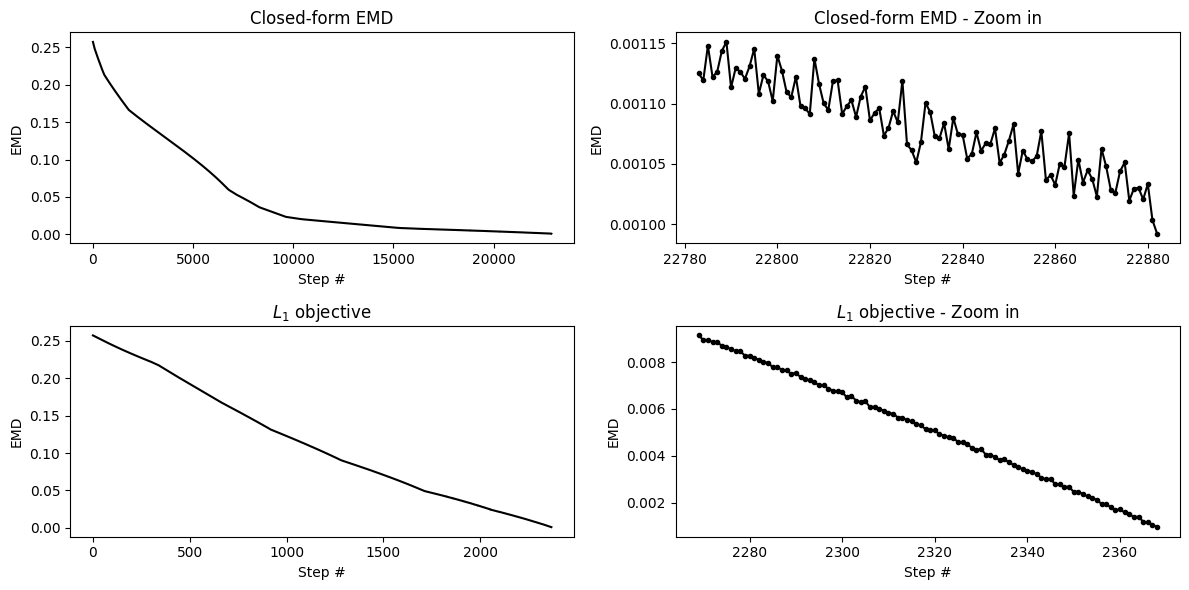

In [9]:
from PIL import Image

Image.open('assets/emd_is_just_mse/trajectories.png')

We can clearly see that $L_1$ objective, for comparison, converges order of magnitude faster than a closed-form solution to the EMD: 2000 vs 20 000 steps. Also the trajectory near the minimum speaks for itself: closed-form objective is much more jagged, which slows down convergence and leads to tons of suboptimal steps and a ridiculous accumulation of error as a result. And the finer the steps get, the more errors they accumulate. 

We can get a feeling of why this happens by looking at the derivative of a closed-form solution. Recall that:

$$ W(h, g) = \frac{1}{n} \sum_{m=1}^{n} \left| \textstyle \sum_{i=1}^{m} h_i - g_i \right| $$

Then its derivative with respect to $h$ is:

$$ \frac{\partial W}{\partial h_k} 
    = \frac{1}{n} \sum_{m=k}^{n} \text{sign} \left( \textstyle \sum_{i=1}^{m} h_i - g_i \right) $$

The graph of the derivative is shown below:

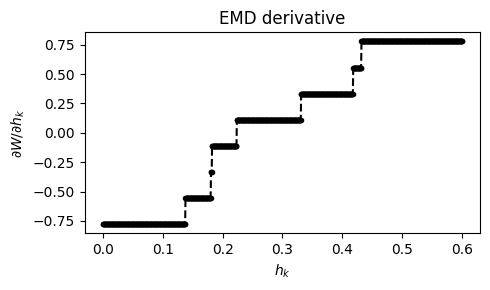

In [10]:
d = 10
k = 3

np.random.seed(49)
h = np.random.exponential(size = d, )
h = h / h.sum()
g = np.random.exponential(size = d)
g = g / g.sum()
np.random.seed(None)

g = g[:,None]
h = h[:,None]
h = h * np.ones(1001)[None,:]

h[k] = np.linspace(0, 0.6, 1001)

dW = 1/(d-1) * np.sum(np.sign(np.cumsum(h - g, axis = 0))[k:], axis = 0)

plt.figure(figsize = (5,3))
plt.title('EMD derivative')
plt.plot(np.linspace(0, 0.6, 1001), dW, 'k.--')
plt.xlabel('$h_k$')
plt.ylabel('$\partial W / \partial h_k$')
plt.tight_layout();

Definitely not the best function to use along gradient methods, with lots of discrete jumps which cause that jaggedness of error curve. I bet the actual trajectory zig-zags like crazy as it tries to move along a slanted line with discrete steps. Also a fun fact is that the derivative has more terms for the bins with smaller indices. This makes a gradient for the first bin more noisy then for the last one, which is somewhat arbitrary. 

The same is true for the KS distance, as its gradient depends on whether a particular index is a maximal CDF difference, which jumps all the time and is also very noisy, which leads to the same error accumulation problem. We can observe that from the results.

# Conclusion

So today we've learned that:

1. Any similarity measure induces an upper bound on any other similarity measure and proved $L_1$ and Kolmogorov-Smirnov upper bounds on EMD, which are optimal in the sense that they are linear and uniform. 
2. $L_2$ distance despite not being equal to the EMD produces optimization trajectories which correspond to valid transport plans, which makes it equivalent to the EMD in that sense
3. Optimizing the exact closed-form solution to the EMD is worse than $L_1$ or $L_2$ surrogates in terms of the EMD itself, as instabilities in the gradient lead to huge accumulation of variational error.

All of that to just conclude, that if you need to match histograms using gradient methods, then you can just use MSE or MAE and don't overthink things when unnecessary.

And by the way, remember, how we glanced over the Euclidean distance:

>  *The instinctive first choice would be a euclidean norm of $P$. But remember, that...*

... and then dived into all the upper bounds stuff? So we have also probably learned to listen to our intuition a bit more.

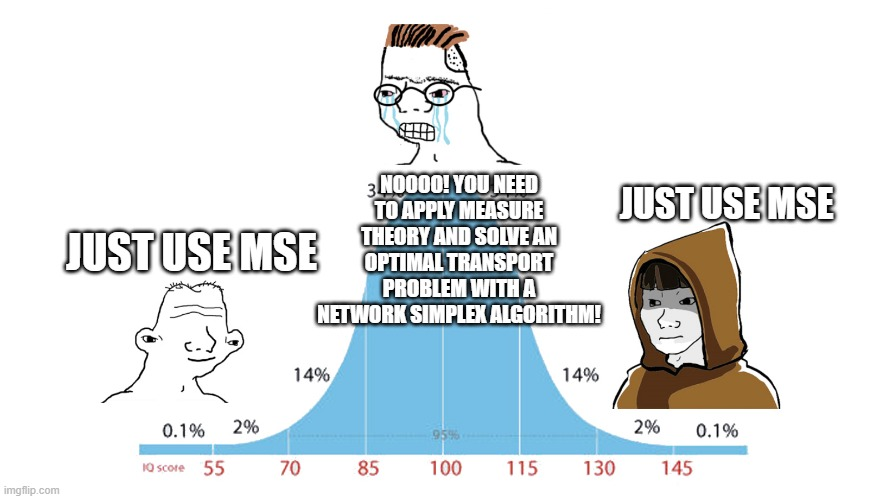

In [11]:
Image.open("assets/emd_is_just_mse/meme.png")

In [12]:
# import torch
# import tqdm
# import numpy as np
# import pickle
# from functools import partial
# from multiprocessing import Pool

# def EMD(h, g):
#     h = h / h.sum()
#     g = g / g.sum()
#     return torch.sum(torch.abs(torch.cumsum(h - g, 0))) / h.size()[0]

# def L1(h, g):
#     h = h / h.sum()
#     g = g / g.sum()
#     return torch.sum(torch.abs(h - g))

# def L2(h, g):
#     h = h / h.sum()
#     g = g / g.sum()
#     return torch.sum(torch.square(h - g))

# def KS(h, g):
#     h = h / h.sum()
#     g = g / g.sum()
#     return torch.max(torch.abs(torch.cumsum(h - g, 0)))


# def experiment(i, d, lr = 1e-3, eps = 1e-2):
#     h = np.random.exponential(size = d)
#     h = h / h.sum()
#     g = np.random.exponential(size = d)
#     g = g / g.sum()

#     x = torch.nn.Parameter(torch.tensor(h, dtype = torch.float))
#     y = torch.tensor(g, dtype = torch.float)
#     opt = torch.optim.SGD([x], lr = lr)

#     emd = float(EMD(x, y).detach())

#     emd_acc = 0
#     while EMD(x, y).detach() > eps:
#         x_prev = torch.tensor(x.detach().numpy())
#         loss = L2(x, y)

#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#         emd_acc += EMD(x, x_prev)

#     return abs(float(emd_acc) - emd) / (emd + eps) * 100

# n = 100
# lr = 1e-4
# worker = partial(experiment, d = 50, lr = lr, eps = lr*10)
# with Pool(12) as pool:
#     data = list(tqdm.tqdm(pool.imap(worker, range(n)), total = n))

# err = np.mean(data)
# print(f'ERROR: {err:.2f}')